In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('fivethirtyeight')

In [2]:
#Bring in our data
game_details = pd.read_csv(r'C:\Users\charl\Python\GitHub Projects\BasketBall-WinPrediction\data\games_details.csv')
games = pd.read_csv(r'C:\Users\charl\Python\GitHub Projects\BasketBall-WinPrediction\data\games.csv')
players = pd.read_csv(r'C:\Users\charl\Python\GitHub Projects\BasketBall-WinPrediction\data\players.csv')
ranking = pd.read_csv(r'C:\Users\charl\Python\GitHub Projects\BasketBall-WinPrediction\data\ranking.csv')
teams = pd.read_csv(r'C:\Users\charl\Python\GitHub Projects\BasketBall-WinPrediction\data\teams.csv')
pd.options.display.width = 0
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-03-01,21900895,Final,1610612766,1610612749,2019,1610612766,85.0,0.354,0.900,...,22.0,47.0,1610612749,93.0,0.402,0.762,0.226,20.0,61.0,0
1,2020-03-01,21900896,Final,1610612750,1610612742,2019,1610612750,91.0,0.364,0.400,...,19.0,57.0,1610612742,111.0,0.468,0.632,0.275,28.0,56.0,0
2,2020-03-01,21900897,Final,1610612746,1610612755,2019,1610612746,136.0,0.592,0.805,...,25.0,37.0,1610612755,130.0,0.505,0.650,0.488,27.0,37.0,1
3,2020-03-01,21900898,Final,1610612743,1610612761,2019,1610612743,133.0,0.566,0.700,...,38.0,41.0,1610612761,118.0,0.461,0.897,0.263,24.0,36.0,1
4,2020-03-01,21900899,Final,1610612758,1610612765,2019,1610612758,106.0,0.407,0.885,...,18.0,51.0,1610612765,100.0,0.413,0.667,0.429,23.0,42.0,1


In [3]:
#Create a smaller table for the purpose of bringing in team abreviations into the games df as it currently only has team ID
team_abv = teams[['TEAM_ID','ABBREVIATION']]
games_new = games.merge(team_abv,left_on = 'HOME_TEAM_ID', right_on = 'TEAM_ID').merge(team_abv,left_on = 'VISITOR_TEAM_ID', right_on = 'TEAM_ID')
games_new.rename(columns={'ABBREVIATION_x':'ABV_HOME',
                         'ABBREVIATION_y':'ABV_AWAY'}, 
                 inplace=True)

#Use only the columns we care about as there was some repition amoung columns
g = games_new.drop(columns = ['GAME_STATUS_TEXT','TEAM_ID_y','TEAM_ID_home','TEAM_ID_away','TEAM_ID_x'])
#Need to filter teams down into just ID and ABV
#then join in twice to games for home and vistor ID. Rename abv columns according to home or away
games_new.head()
g.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,ABV_HOME,ABV_AWAY
0,2020-03-01,21900895,1610612766,1610612749,2019,85.0,0.354,0.900,0.229,22.0,47.0,93.0,0.402,0.762,0.226,20.0,61.0,0,CHA,MIL
1,2020-01-24,21900669,1610612766,1610612749,2019,103.0,0.372,0.833,0.359,24.0,39.0,116.0,0.506,0.750,0.278,26.0,53.0,0,CHA,MIL
2,2013-12-23,21300407,1610612766,1610612749,2013,111.0,0.434,0.750,0.588,30.0,43.0,110.0,0.433,0.941,0.357,29.0,51.0,1,CHA,MIL
3,2013-11-29,21300228,1610612766,1610612749,2013,92.0,0.443,0.613,0.200,20.0,54.0,76.0,0.333,0.750,0.294,17.0,38.0,1,CHA,MIL
4,2013-04-13,21201190,1610612766,1610612749,2012,95.0,0.463,0.708,0.444,23.0,52.0,85.0,0.391,0.667,0.310,23.0,36.0,1,CHA,MIL


# Visualization

Perform some visualization. Some of it is unrelated to the model we are going to build, but it is always interesting to learn a little more about your data 

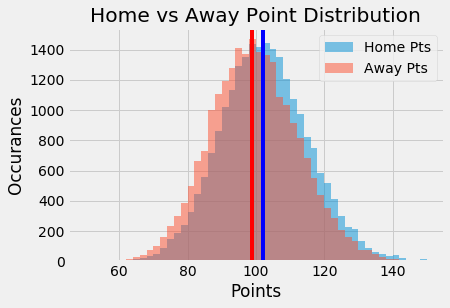

In [4]:
plt.hist('PTS_home',data=g, bins = 50, range= (50,150),alpha = .5, label = 'Home Pts')
plt.hist('PTS_away',data=g, bins  =50, range=(50,150),alpha = .5, label = 'Away Pts')
plt.title('Home vs Away Point Distribution')
plt.xlabel('Points')
plt.ylabel('Occurances')
plt.legend()

home_median = g.PTS_home.median()
away_median = g.PTS_away.median()
plt.axvline(home_median, color = 'blue')
plt.axvline(away_median, color = 'red')

plt.show()

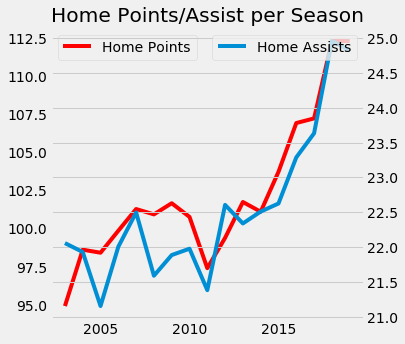

In [5]:
#Group stats by season
season_gp = g.groupby('SEASON').mean().reset_index()

fig, ax1 = plt.subplots(figsize=(5,5))

#Set up a 2nd axis
ax2 = ax1.twinx() 

ax1.plot(season_gp.SEASON, season_gp.PTS_home, color = 'r', label = 'Home Points')
plt.title('Average Home Points per Season')

ax2.plot(season_gp.SEASON, season_gp.AST_home, label = 'Home Assists')
plt.title('Home Points/Assist per Season')

ax1.grid(False) #Need to hide one of the gridlines as they don't align

ax1.legend()
ax2.legend(loc=1)

#This isn't relevant to our overall analysis and predictive model, but it is still interesting

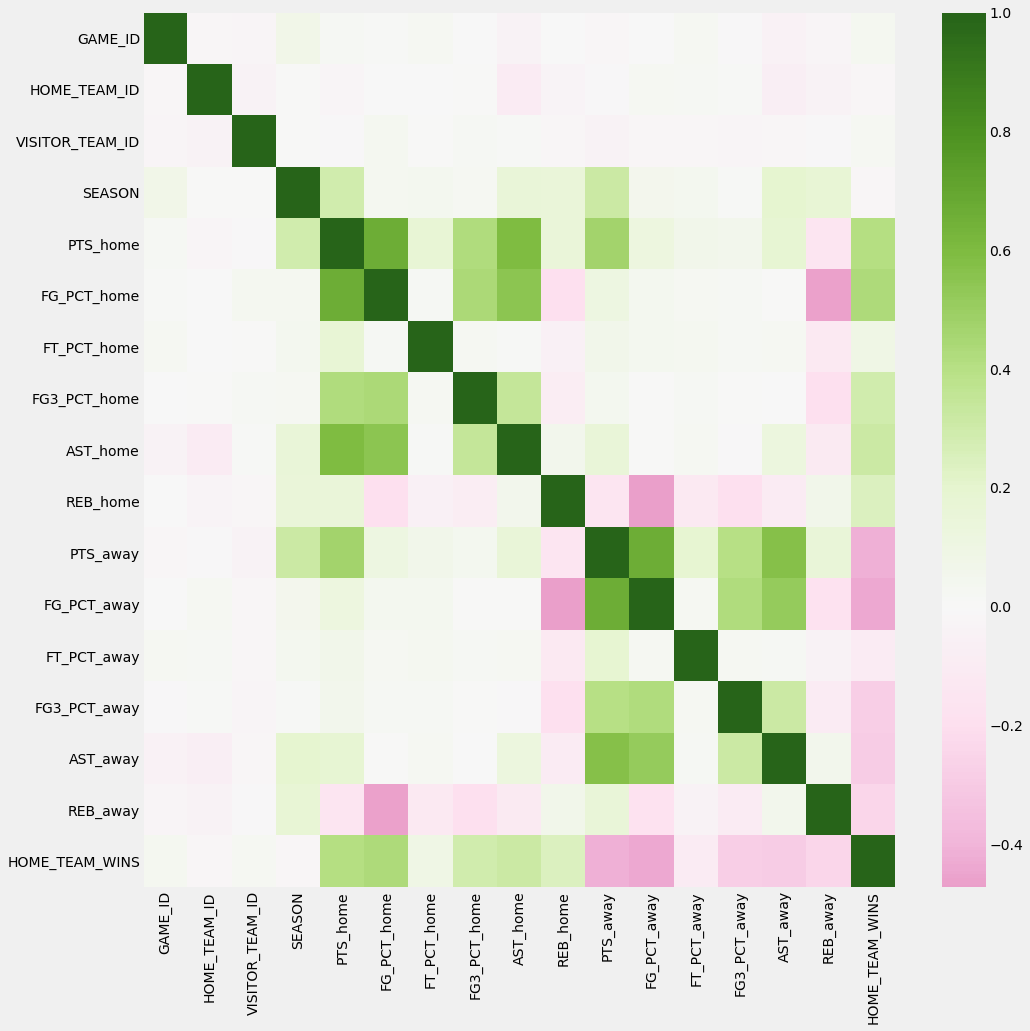

In [9]:
#Find correlations in the game outcome and stats of THAT game
#Basically all below stats have some effect on wins except for free throws
plt.figure(figsize=(15,15))
sns.heatmap(g.corr(), center = 0, cmap = 'PiYG')

# Bring In All Stats for Data Prep

We can see that all of these stats except for the descriptive stats (season, game_id etc) and Free Throw Percentage are somewhat significant. We will drop FGP later as a result. 

Let's add some stats from the game_details df like rebounds 

To do this we need to take the game_details and group by gameID

In [12]:
game_details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,...,4.0,4.0,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0
1,21900895,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,F,NaN,34:55,17.0,...,2.0,18.0,20.0,6.0,1.0,0.0,3.0,2.0,41.0,22.0
2,21900895,1610612749,MIL,Milwaukee,201572,Brook Lopez,C,NaN,26:25,4.0,...,2.0,5.0,7.0,0.0,0.0,3.0,0.0,2.0,16.0,16.0
3,21900895,1610612749,MIL,Milwaukee,1628978,Donte DiVincenzo,G,NaN,27:35,1.0,...,1.0,6.0,7.0,5.0,0.0,1.0,2.0,0.0,2.0,14.0
4,21900895,1610612749,MIL,Milwaukee,202339,Eric Bledsoe,G,NaN,22:17,2.0,...,1.0,0.0,1.0,2.0,1.0,0.0,3.0,2.0,4.0,6.0


In [13]:
#Create a game_details df that has home wins included
full_dets = game_details.merge(g[['GAME_ID','ABV_HOME','HOME_TEAM_WINS']],left_on = 'GAME_ID', right_on='GAME_ID')
full_dets.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,ABV_HOME,HOME_TEAM_WINS
0,21900895,1610612749,MIL,Milwaukee,202083,Wesley Matthews,F,NaN,27:08,3.0,...,8.0,2.0,2.0,0.0,0.0,0.0,8.0,11.0,CHA,0
1,21900895,1610612749,MIL,Milwaukee,203507,Giannis Antetokounmpo,F,NaN,34:55,17.0,...,20.0,6.0,1.0,0.0,3.0,2.0,41.0,22.0,CHA,0
2,21900895,1610612749,MIL,Milwaukee,201572,Brook Lopez,C,NaN,26:25,4.0,...,7.0,0.0,0.0,3.0,0.0,2.0,16.0,16.0,CHA,0
3,21900895,1610612749,MIL,Milwaukee,1628978,Donte DiVincenzo,G,NaN,27:35,1.0,...,7.0,5.0,0.0,1.0,2.0,0.0,2.0,14.0,CHA,0
4,21900895,1610612749,MIL,Milwaukee,202339,Eric Bledsoe,G,NaN,22:17,2.0,...,1.0,2.0,1.0,0.0,3.0,2.0,4.0,6.0,CHA,0


In [14]:
#Using hometeam win to create a standard 'win' column
full_dets['WIN'] = np.where(full_dets['TEAM_ABBREVIATION']==full_dets['ABV_HOME'],
                              full_dets['HOME_TEAM_WINS'],
                                  np.where(full_dets['HOME_TEAM_WINS']==1,
                                          0,1))

In [15]:
#Drop useless columns
game_win = full_dets.drop(columns = ['COMMENT','PLAYER_ID','MIN','FT_PCT','TO'])

#Now we need to aggregate this data by Game ID as we have individual player stats for each game
#Can sum each players stats so that we can get team stats for each game
#Need to group by Team Abv as well to seperate out Home and Away stats
game_gp = game_win.groupby(['GAME_ID','TEAM_ID','TEAM_ABBREVIATION','ABV_HOME']).sum().reset_index()

#Wins were being summed due to grouping. Ensure that still a binary classification
game_gp['WIN'] = np.where(game_gp['WIN'] > 0,1,0)
game_gp['HOME_TEAM_WINS'] = np.where(game_gp['HOME_TEAM_WINS'] > 0,1,0)
game_gp.head(7)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
0,10300001,1610612742,DAL,UTA,34.0,76.0,4.177,2.0,8.0,1.000,...,26.0,38.0,20.0,9.0,4.0,34.0,85.0,0.0,1,0
1,10300001,1610612762,UTA,UTA,32.0,70.0,9.758,1.0,7.0,1.000,...,32.0,41.0,23.0,8.0,4.0,26.0,90.0,0.0,1,1
2,10300002,1610612749,MIL,MEM,32.0,75.0,4.521,2.0,13.0,0.500,...,32.0,43.0,20.0,9.0,4.0,26.0,94.0,0.0,1,0
3,10300002,1610612763,MEM,MEM,40.0,81.0,6.789,4.0,15.0,1.367,...,34.0,48.0,25.0,18.0,7.0,35.0,105.0,0.0,1,1
4,10300003,1610612739,CLE,DET,38.0,77.0,5.051,4.0,6.0,1.500,...,40.0,52.0,25.0,10.0,7.0,33.0,100.0,0.0,0,1
5,10300003,1610612765,DET,DET,34.0,87.0,5.448,4.0,9.0,2.667,...,25.0,37.0,19.0,15.0,3.0,27.0,96.0,0.0,0,0
6,10300004,1610612742,DAL,DAL,40.0,82.0,5.600,1.0,6.0,1.000,...,37.0,52.0,20.0,9.0,5.0,30.0,99.0,0.0,1,1


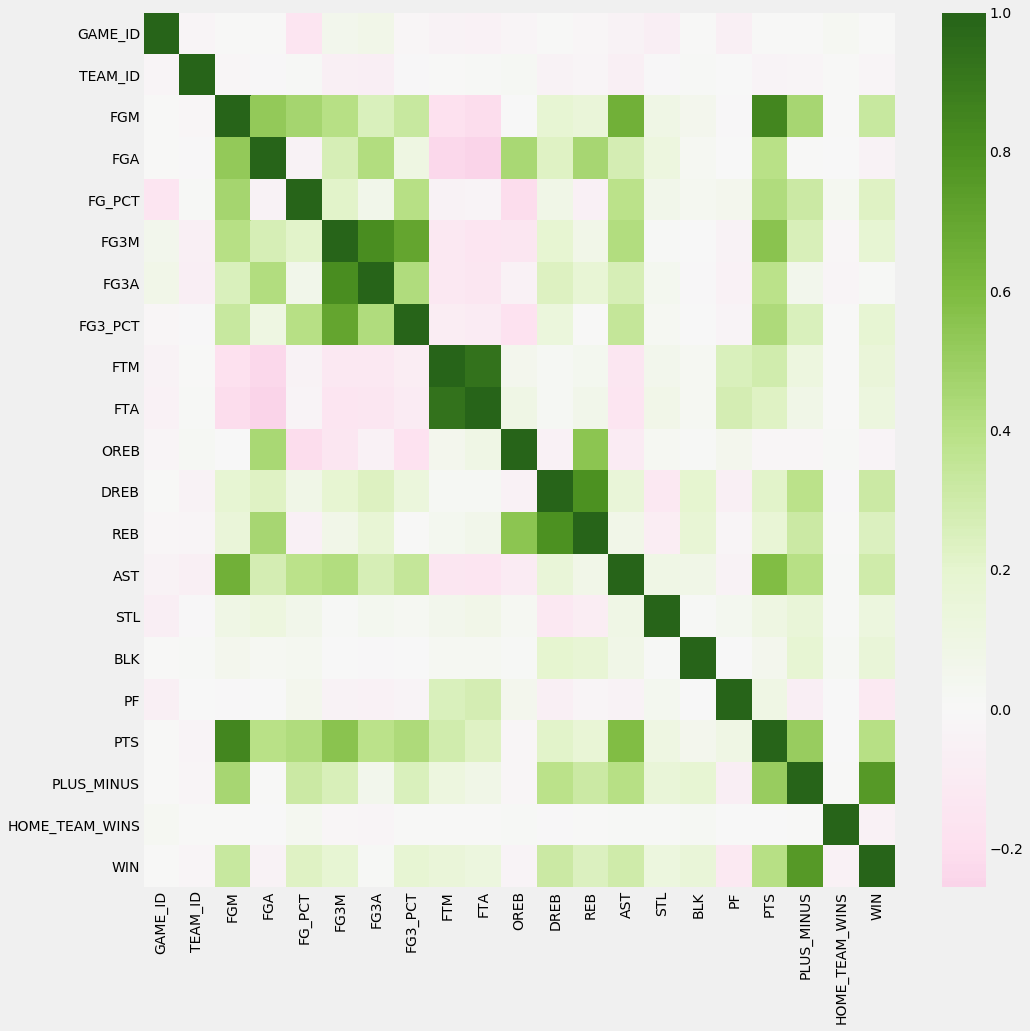

In [16]:
#Heat map of new game stats and their correlation
plt.figure(figsize = (15,15))
sns.heatmap(game_gp.corr(),cmap = 'PiYG', center = 0)

Only look at the WIN column for this heatmap... Home_team_wins is meaningless for the heatmap since each row in the df is not always a home game and the stats are not differentiated between home and away

Interesting that defensive rebounds have a correlation to wins, but offensive rebounds have no correlation at all

# Apply Moving Average

We now have a better picture of which stats correlate to a win.

However, to predict a game outcome, we cannot just use that game's stats. The whole point of predicting a game outcome is to do so before it occurs, so we obviously cannot use the same game stats to predict it's outcome. 

Intead we will use a moving average of the last X games to predict the outcome.

We will also need to create a df that includes both the home AND away stats as the difference between the teams will be an important factor in predicting the outcome.

In [12]:
#These are the stats we are going to turn into a moving average
game_gp.loc[:,'FGM':'PLUS_MINUS'].loc[game_gp['PLUS_MINUS']!=0].head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS
1917,36.0,78.0,6.928,14.0,32.0,4.250,12.0,17.0,10.0,32.0,42.0,19.0,6.0,6.0,25.0,98.0,60.0
1918,31.0,72.0,5.309,5.0,15.0,2.333,19.0,28.0,10.0,32.0,42.0,18.0,11.0,3.0,17.0,86.0,-60.0
1919,30.0,64.0,5.414,5.0,13.0,1.900,29.0,40.0,13.0,32.0,45.0,18.0,6.0,4.0,27.0,94.0,-25.0
1920,33.0,75.0,6.169,6.0,18.0,3.916,27.0,35.0,7.0,23.0,30.0,21.0,10.0,3.0,31.0,99.0,25.0
1921,25.0,74.0,3.831,8.0,21.0,2.517,23.0,32.0,12.0,28.0,40.0,18.0,8.0,7.0,24.0,81.0,-20.0


In [13]:
#The first game that has a valid plus minus is 1917. We can just drop all columns before this, since it is a significant feature
game_gp.drop(game_gp.iloc[:1917].index, inplace=True)

In [14]:
#Let's create a moving ave of every stat
roll_test = game_gp.copy()
#Important to shift by 1 so we do not include that games stats in the prediction
roll_test.loc[:,'TEAM_ID':'PLUS_MINUS'] = roll_test.loc[:,'TEAM_ID':'PLUS_MINUS'].rolling(window=5, on = 'TEAM_ID').mean().shift(1)

In [15]:
roll_test.head(6)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
1917,11400001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1918,11400001,1.610613e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1919,11400002,1.610613e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1920,11400002,1.610613e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1921,11400004,1.610613e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1922,11400004,1.610613e+09,NaN,NaN,31.0,72.6,5.5302,7.6,19.8,2.9832,...,29.4,39.8,18.8,8.2,4.6,24.8,91.6,-4.0,0,1


The roll_test DF is not useable yet. It does not take into account the TEAM_ID when performing the moving ave meaning it is combining stats from different teams.

It's purpose was just to explore the rolling function of pandas.

We will now create a df that does the rolling ave properly by sorting each team chronoligically on their Team ID

In [16]:
roll = game_gp.copy()

In [17]:
#Create a df where each team is grouped so that we can calculate a moving average
#Sort by TEAM_ID and ABV just to make sure that these are lining up as intended
#Sort by ABV_HOME so that we seperate out the home and away teams
#Sort by game_ID so games are chronological
roll_gp = roll.groupby(['TEAM_ID','TEAM_ABBREVIATION','GAME_ID','ABV_HOME']).sum().reset_index()
roll_gp.head(5)



,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
0,1610612737,ATL,11400007,ATL,31.0,74.0,4.538,8.0,19.0,4.000,...,36.0,50.0,24.0,6.0,5.0,26.0,93.0,30.0,1,1
1,1610612737,ATL,11400035,MEM,32.0,75.0,4.972,8.0,25.0,2.717,...,33.0,42.0,22.0,4.0,7.0,21.0,88.0,-25.0,1,0
2,1610612737,ATL,11400052,MIA,39.0,80.0,6.421,13.0,34.0,3.583,...,36.0,45.0,27.0,5.0,7.0,22.0,109.0,30.0,0,1
3,1610612737,ATL,11400060,CHI,31.0,80.0,5.201,7.0,27.0,2.166,...,37.0,46.0,21.0,7.0,6.0,30.0,84.0,-5.0,1,0
4,1610612737,ATL,11400077,ATL,36.0,84.0,5.060,11.0,27.0,3.258,...,35.0,43.0,28.0,8.0,3.0,24.0,100.0,-20.0,0,0


We now have the DF formatted so we can apply a rolling average to each team. 

In [18]:
#Test to apply mva to Atlanta only
r_test = roll_gp.copy()
r_test.loc[:,'FGM':'PLUS_MINUS'] = r_test.loc[r_test['TEAM_ABBREVIATION'] == 'ATL','FGM':'PLUS_MINUS'].rolling(window=5).mean().shift(1)
r_test.head(7)

,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
0,1610612737,ATL,11400007,ATL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,1610612737,ATL,11400035,MEM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,1610612737,ATL,11400052,MIA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,1610612737,ATL,11400060,CHI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,1610612737,ATL,11400077,ATL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,1610612737,ATL,11400089,ATL,33.8,78.6,5.2384,9.4,26.4,3.1448,...,35.4,45.2,24.4,6.0,5.6,24.6,94.8,2.0,1,1
6,1610612737,ATL,11400105,SAS,35.2,80.6,5.3648,9.2,27.6,2.9448,...,34.8,43.2,25.0,7.2,5.6,24.4,99.6,-1.0,0,1


In [19]:
tnames = roll_gp.TEAM_ABBREVIATION.unique() #Create list of team abvs
r = roll_gp.copy() 

#loop through all the teams to apply a rolling average
for i in tnames:
    r.loc[r['TEAM_ABBREVIATION'] == i,'FGM':'PLUS_MINUS'] = r.loc[r['TEAM_ABBREVIATION'] == i,'FGM':'PLUS_MINUS'].rolling(window=5).mean().shift(1)

In [20]:
#Bring games back into chronoligcal order
r = r.sort_values(by='GAME_ID')

In [21]:
#Let's check later in the df to make sure everything worked. 
#Can't use head since the first games will all be nan as each team needs to play 5 games before values will appear.
r.iloc[400:405]

,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
7510,1610612742,DAL,11500103,CHI,31.0,81.4,4.2816,5.8,27.0,1.5198,...,35.6,44.4,17.8,7.8,5.4,21.8,87.6,-64.0,1,0
6025,1610612741,CHI,11500103,CHI,37.8,85.6,4.6094,10.2,28.4,3.0092,...,36.8,49.0,20.6,6.6,3.2,25.0,101.8,-21.0,1,1
5424,1610612740,NOP,11500104,NOP,34.6,82.8,4.7590,8.4,25.6,2.5274,...,35.6,43.4,16.2,10.0,4.6,24.8,104.2,-34.0,1,1
16498,1610612748,MIA,11500104,NOP,36.2,87.2,5.2060,7.4,26.2,2.5482,...,37.0,49.0,21.2,7.8,4.8,18.6,101.0,19.0,1,0
18065,1610612749,MIL,11500105,MIN,37.4,81.4,5.4442,6.6,20.0,2.0874,...,35.6,46.6,22.0,7.6,5.8,29.8,100.0,-16.0,1,0


# Data Prep

We now have all of the games with a 5 game rolling average for each team

We need to include the home and away team stats in each row in order to train our model. 

To do this we will create two dfs, one for home and one for away, and then merge them together on GAME_ID.

In [22]:
r_home = r.loc[r['TEAM_ABBREVIATION']==r['ABV_HOME']]
r_away = r.loc[r['TEAM_ABBREVIATION']!=r['ABV_HOME']]
r_home.head()

,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,ABV_HOME,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,PF,PTS,PLUS_MINUS,HOME_TEAM_WINS,WIN
16483,1610612748,MIA,11400001,MIA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
35593,1610612761,TOR,11400002,TOR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
6010,1610612741,CHI,11400004,CHI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
14960,1610612747,LAL,11400005,LAL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1486,1610612738,BOS,11400006,BOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [23]:
r_fin = r_home.merge(r_away, on = 'GAME_ID',suffixes=('_home','_away'))
r_fin.head()

,TEAM_ID_home,TEAM_ABBREVIATION_home,GAME_ID,ABV_HOME_home,FGM_home,FGA_home,FG_PCT_home,FG3M_home,FG3A_home,FG3_PCT_home,...,DREB_away,REB_away,AST_away,STL_away,BLK_away,PF_away,PTS_away,PLUS_MINUS_away,HOME_TEAM_WINS_away,WIN_away
0,1610612748,MIA,11400001,MIA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,1610612761,TOR,11400002,TOR,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,1610612741,CHI,11400004,CHI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,1610612747,LAL,11400005,LAL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,1610612738,BOS,11400006,BOS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [24]:
#Drop redundant and useless columns
r_fin.drop(columns = ['HOME_TEAM_WINS_home','WIN_home','TEAM_ID_away','TEAM_ABBREVIATION_away','ABV_HOME_away','WIN_away'],inplace=True)

In [25]:
r_fin.rename(columns={'HOME_TEAM_WINS_away':'HOME_TEAM_WINS'}, inplace=True)

All games are now formatted so that they are home team on the left. Our hypothesis will be that home team wins. 

# Feature Selection

In [26]:
r_fin.dropna(inplace=True) # Drop the first 5 games for each team since they are NaN

In [27]:
#Let's select our best features before we go any further
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


x = r_fin.loc[:,'FGM_home':'PLUS_MINUS_away']
y = r_fin['HOME_TEAM_WINS']

fvalue_selector = SelectKBest(f_classif, k=24)

fvalue_selector.fit(x, y)

dfscores = pd.DataFrame(fvalue_selector.scores_)
dfcolumns = pd.DataFrame(x.columns)

In [28]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(24,'Score')) 

              Specs       Score
16  PLUS_MINUS_home  846.944530
33  PLUS_MINUS_away  644.148123
19      FG_PCT_away  143.901620
32         PTS_away  140.759581
20        FG3M_away  132.166003
28         AST_away  117.719195
15         PTS_home  113.170834
26        DREB_away  106.585318
21        FG3A_away  101.149815
22     FG3_PCT_away   93.590082
13         BLK_home   93.147819
11         AST_home   90.997014
17         FGM_away   87.366027
0          FGM_home   71.250036
2       FG_PCT_home   60.057486
30         BLK_away   53.812710
14          PF_home   39.462580
9         DREB_home   38.520197
27         REB_away   37.065706
31          PF_away   36.291858
3         FG3M_home   30.243351
6          FTM_home   29.239459
29         STL_away   28.746964
25        OREB_away   28.425666


In [29]:
cols = featureScores.nlargest(9,'Score').Specs #Select Features with score > 100
cols = [i for i in cols] #Get significant column names in a list so we can easily filter df

# Model Selection

In [30]:
#Import libraries to scale data and and split into test/training sets 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#new x values only contain top 9 best features 
x1 = r_fin[cols]
y1 = r_fin['HOME_TEAM_WINS']

#Scalde data as we will be testing many models, some of which require scaled data
x1_scale=StandardScaler().fit_transform(x1)

x1_train, x1_test, y1_train, y1_test = train_test_split(x1_scale,y1)

In [31]:
#Import classifiers
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Apply cross validation to each type of model to assess the strongest model for the data 

In [33]:
cross_val_score(LogisticRegression(), x1_scale, y1).mean()

0.6339615487857012

In [33]:
cross_val_score(SVC(), x1_scale, y1).mean()

0.6261173889976963

In [34]:
cross_val_score(RandomForestClassifier(), x1_scale, y1).mean()

0.611855806138782

In [35]:
cross_val_score(DecisionTreeClassifier(), x1_scale, y1).mean() 
#No point in really having this as GB is always better, but it's fast so may as well..

0.5404067636683745

In [36]:
cross_val_score(KNeighborsClassifier(), x1_scale, y).mean()

0.575157102818858

In [37]:
cross_val_score(GaussianNB(), x1_scale, y).mean()

0.6061507572477882

In [38]:
cross_val_score(GradientBoostingClassifier(), x1_scale, y).mean()

0.6283991871233984

Logistic Regression wins! 

Sometimes GBClassifier has a higher score, but since it is so much slower, we will stick to using and tuning log_reg

# Hyperparamater Tuning

In [32]:
#import GridSearchCV so we can find best combination of attributes
from sklearn.model_selection import GridSearchCV

params={'C':np.logspace(-3,3,7), 'penalty':['l1','l2'],'solver' : ['liblinear']} # l1 lasso, l2 ridge
logreg = LogisticRegression()

logreg_cv=GridSearchCV(logreg,params)
logreg_cv.fit(x1_train,y1_train)

print("tuned hpyerparameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.6359255733048916


# Model Evaluation

              precision    recall  f1-score   support

           0       0.58      0.32      0.41      2102
           1       0.65      0.84      0.73      3157

    accuracy                           0.63      5259
   macro avg       0.61      0.58      0.57      5259
weighted avg       0.62      0.63      0.61      5259



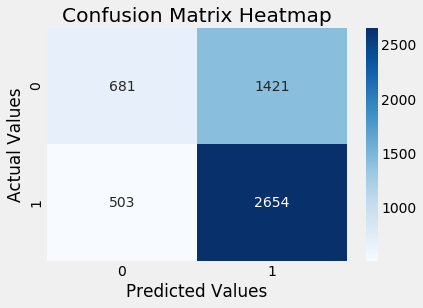

In [36]:
from sklearn.metrics import classification_report, confusion_matrix


y1_pred = logreg_cv.predict(x1_test)

cfn_matrix = confusion_matrix(y1_test, y1_pred, labels = [0,1])
cfn_report = classification_report(y1_test, y1_pred)

sns.heatmap(cfn_matrix, annot=True, fmt = 'd', cmap="Blues").set_title('Confusion Matrix Heatmap')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

print(cfn_report)

In [37]:
tn, fp, fn, tp = cfn_matrix.ravel()
(tn, fp, fn, tp)

(681, 1421, 503, 2654)

In [38]:
from sklearn.metrics import log_loss
y1_prob = logreg_cv.predict_proba(x1_test)

log_loss(y1_test, y1_prob)

0.6360835331296516

In [52]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y1_test, y1_prob[:,1], pos_label=1) 
AUC = auc(fpr, tpr)

AUC

0.6569350215355181

### Our first run through did not yield exceptional results, with a notable weakness on recall
We will now see if we can improve our model through more refined feature selection/engineering

# Part 2 
## Improving Feature Selection/Engineering With Exponential Moving Average
Assuming that more recent games are more important, let's improve our features by applying a moving average that weights recent games higher

We are going to apply the same 'pipeline' that I used earlier with this new MVA technique

In [53]:
roll_exp = game_gp.copy()

In [54]:
#Apply Exponential Moving average to each team
#Tried multiple Spans and arrived at 50 as the best... in Future make this process a pipeline to iterate through more options
for i in tnames:
    roll_exp.loc[roll_exp['TEAM_ABBREVIATION'] == i,'FGM':'PLUS_MINUS'] = roll_exp.loc[roll_exp['TEAM_ABBREVIATION'] == i,'FGM':'PLUS_MINUS'].ewm(span=50,adjust=False).mean().shift(1)

In [55]:
#Split teams into home and away so we can have stats in one row
roll_exp_home = roll_exp.loc[roll_exp['TEAM_ABBREVIATION']==roll_exp['ABV_HOME']]
roll_exp_away = roll_exp.loc[roll_exp['TEAM_ABBREVIATION']!=roll_exp['ABV_HOME']]

In [56]:
roll_exp_fin = roll_exp_home.merge(roll_exp_away, on = 'GAME_ID',suffixes=('_home','_away'))

In [57]:
roll_exp_fin.drop(columns = ['HOME_TEAM_WINS_home','WIN_home','TEAM_ID_away','TEAM_ABBREVIATION_away','ABV_HOME_away','WIN_away'],inplace=True)

roll_exp_fin.rename(columns={'HOME_TEAM_WINS_away':'HOME_TEAM_WINS'}, inplace=True)

In [58]:
roll_exp_fin.iloc[100:105]

,GAME_ID,TEAM_ID_home,TEAM_ABBREVIATION_home,ABV_HOME_home,FGM_home,FGA_home,FG_PCT_home,FG3M_home,FG3A_home,FG3_PCT_home,...,OREB_away,DREB_away,REB_away,AST_away,STL_away,BLK_away,PF_away,PTS_away,PLUS_MINUS_away,HOME_TEAM_WINS
100,11400112,1610612763,MEM,MEM,32.583757,78.193660,7.807539,3.481417,12.927759,1.212630,...,9.880251,31.424910,41.305161,18.546474,11.255160,3.274089,18.467061,90.324231,-47.051980,0
101,11400113,1610612745,HOU,HOU,35.231027,78.810418,5.815884,9.817842,26.525117,2.635790,...,7.327280,33.692486,41.019766,20.600191,8.746538,1.453792,19.345184,91.921116,-138.655532,1
102,11400114,1610612762,UTA,UTA,34.649268,77.081863,5.867370,7.168285,15.592139,2.703557,...,11.473687,34.930673,46.404359,16.699804,7.541700,2.291314,21.763923,98.649151,39.716453,0
103,11400115,1610612747,LAL,LAL,38.342807,85.990489,5.080418,4.415957,9.922814,2.382571,...,12.514262,31.772279,44.286541,18.185610,6.407423,4.216016,26.579791,95.759701,-24.081038,0
104,11400116,1610612761,TOR,TOR,33.665111,75.727389,6.169556,6.459998,19.090644,3.725710,...,8.524365,30.527166,39.051531,20.276649,7.387307,5.572178,23.307329,87.371861,-80.660886,1


In [59]:
roll_exp_fin.dropna(inplace=True)

#Let's select our best features before we go any further
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

x = roll_exp_fin.loc[:,'FGM_home':'PLUS_MINUS_away']
y = roll_exp_fin['HOME_TEAM_WINS']

fvalue_selector = SelectKBest(f_classif, k=24)

fvalue_selector.fit(x, y)

dfscores = pd.DataFrame(fvalue_selector.scores_)
dfcolumns = pd.DataFrame(x.columns)

In [60]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(24,'Score')) 

              Specs        Score
16  PLUS_MINUS_home  1489.171799
33  PLUS_MINUS_away  1136.154977
13         BLK_home   193.254133
28         AST_away   166.654519
26        DREB_away   164.755032
32         PTS_away   160.569120
15         PTS_home   134.662518
11         AST_home   129.492756
20        FG3M_away   126.227513
19      FG_PCT_away   121.302088
22     FG3_PCT_away   100.449344
30         BLK_away    99.546980
17         FGM_away    97.624610
27         REB_away    90.483643
21        FG3A_away    78.227839
0          FGM_home    78.141480
9         DREB_home    71.632781
2       FG_PCT_home    69.936661
6          FTM_home    67.704846
10         REB_home    46.948773
31          PF_away    46.541280
14          PF_home    44.863859
7          FTA_home    40.081021
1          FGA_home    40.059548


In [61]:
x2 = roll_exp_fin[cols] #Use same columns as last time
y2 = roll_exp_fin['HOME_TEAM_WINS']

#Scalde data as we will be testing many models, some of which require scaled data
x2_scale=StandardScaler().fit_transform(x2)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2_scale,y2)

In [62]:
cross_val_score(LogisticRegression(), x2_scale, y2).mean()

0.6648339588291653

In [63]:
params={'C':np.logspace(-3,3,7), 'penalty':['l1','l2'],'solver' : ['liblinear']} # l1 lasso, l2 ridge
logreg1 = LogisticRegression()

logreg_cv1=GridSearchCV(logreg1,params)
logreg_cv1.fit(x2_train,y2_train)

print("tuned hpyerparameters: ",logreg_cv1.best_params_)
print("accuracy :",logreg_cv1.best_score_)

tuned hpyerparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.6637612172751972


              precision    recall  f1-score   support

           0       0.61      0.44      0.51      2070
           1       0.69      0.81      0.75      3208

    accuracy                           0.67      5278
   macro avg       0.65      0.63      0.63      5278
weighted avg       0.66      0.67      0.66      5278



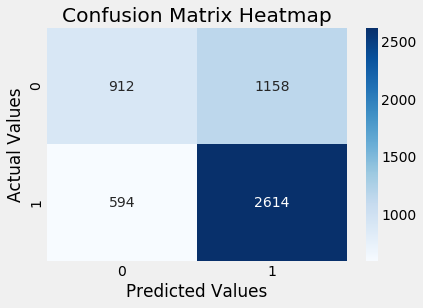

In [64]:
from sklearn.metrics import classification_report, confusion_matrix


y2_pred = logreg_cv1.predict(x2_test)

cfn_matrix1 = confusion_matrix(y2_test, y2_pred, labels = [0,1])
cfn_report1 = classification_report(y2_test, y2_pred)

sns.heatmap(cfn_matrix1, annot=True, fmt = 'd', cmap="Blues").set_title('Confusion Matrix Heatmap')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

print(cfn_report1)

In [65]:
tn1, fp1, fn1, tp1 = cfn_matrix.ravel()
(tn, fp, fn, tp)

(681, 1421, 503, 2654)

In [66]:
from sklearn.metrics import log_loss
y2_prob = logreg_cv1.predict_proba(x2_test)

log_loss(y2_test, y2_prob)

0.6105084673947487

In [68]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y2_test, y2_prob[:,1], pos_label=1) 
AUC = auc(fpr, tpr)

AUC

0.7023501030033611

Our model has improved significantly
- Accuracy improved by ~3%
- Log_loss decrease of ~ -0.02
- AUC increase of ~ 0.04
- Marginal Improvement in both Precision and Recall